# Week 2 - Linear Regression
    
In Week 2, Andrew Ng covers linear regression with single and multiple variables. We're also going to understand how to implement the learning algorithms in practice. I will follow the theory given in the reading material, video lectures and slides from Andrew Ng (Machine Learning course - Coursera).

During the course you will need to use Octave or MATLAB to complete the programming assignments, but here in this notebook I will implement all algorithms using Python (yes, I do love Python).

So lets implement a linear regression algorithm and get to see it work on data. This first programming assignment starts with the simplest case: **regression with a univariate linear function** (otherwise, known as *'fitting a straight line'*) and then (part 2) a **multivariate case**.

## Linear Regression Review

To establish notation for future use, we’ll use $x^{(i)}$ to denote the “input” variables (living area in this example), also called input features, and $y^{(i)}$ to denote the “output” or target variable that we are trying to predict (price).

<img src="./imgs/model_representation.png" style="width: 200px;"/>

To describe the supervised learning problem slightly more formally, our goal is, given a training set, to learn a function $h : X → Y$ so that $h(x)$ is a “good” predictor for the corresponding value of $y$. For historical reasons, **this function h is called a hypothesis**. 

A univariate linear function has an input $x$ and output $y$ in the form $y = \theta_0 + \theta_1x $. Here, $\theta_0 \text{ and } \theta_1$ are the real-valued parameters to be learned. We will define $\theta$ as the vector $[ \theta_0, \theta_1 ]$ and also define:

$$ h_\theta(x) = \theta_0 + \theta_1 x$$

For example, the file `ex1data1.txt` provided for this assignment contains the dataset for our linear regression problem. The first column ($x$) is the population of a city and the second column ($y$) is the profit of a food truck in that city (a negative value for profit indicates a loss).

<img src="./imgs/week2_plot.png" style="width: 200px;"/>

The figure above shows the set of all 97 points in the $x, y$ plane. The task is finding the $h_\theta$ that best fits these data. This is what we call **linear regression** :)

To fit a line to this data, we have train a machine learning model that will find the values of the weights $[\theta_0, \theta_1]$ that minimizes the **loss function** or **cost function**. It common to use the **mean squared error** (or squared error function) summed over all the dataset samples:

$$ J(\theta_0,\theta_1) = J(\theta) = \frac{1}{2m} \sum_{i=1}^{m}(h_\theta(x_i) - y_i) ^ 2 $$

The mean is halved ($\frac{1}{2}$) just as a convenience for better computation of the gradient descent. This is because the derivative term of the squared function will concel out the $\frac{1}{2}$ term.

So we have our hypothesis function and we have a way of measuring how well it fits into the data. Now we need to estimate the parameters in the hypothesis function. That's where gradient descent comes in.

We will know that we have succeeded when our cost function is at the very bottom of the pits in our graph, i.e. when its value is the minimum.

To minimize the loss function means to find $\theta^{*} = argmin_\theta Loss(h_\theta)$. It is minimized when its partial derivatives w.r.t. $\theta_0 \text{ and } \theta_1$ are **zero**.

$$ \frac{\partial}{\partial \theta_0} J(\theta) = (h_\theta(x_i) - y_i) $$
$$ \frac{\partial}{\partial \theta_1} J(\theta) = (h_\theta(x_i) - y_i) x_i $$

When handling problems with only one single feature (one variable) we get the following learning rule for the weights (repet until convergence):

\begin{equation}
  \text{repeat:} =
    \begin{cases}
      \theta_0 :=& \theta_0 - \alpha \frac{1}{m}\sum_{i=1}^{m}(h_\theta(x_i) - y_i)\\
      \theta_1 :=& \theta_1 - \alpha \frac{1}{m}\sum_{i=1}^{m} ((h_\theta(x_i) - y_i) x_i)\\
    \end{cases}       
\end{equation}

So, now I will implement a linear regression model with one variable to predict profits for a food truck. 

## 1. Linear Regression with one variable

### 1.1 Plotting the Data

Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities.

You would like to use this data to help you select which city to expand to next.

Before starting on any task, it is often useful to understand the data by visualizing it. 

For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population). Many other problems that you will encounter in real life are multi-dimensional and can’t be plotted on a 2-d plot.

In `ex1.m`, the dataset is loaded from the data file into the variables X and y:

In [2]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
# load the dataset with profit and population
df = pd.read_csv("./data/ex1data1.txt", names=["profit", "population"])

# overview of our dataset
print("[INFO] Overview of our dataset...\n")
df.info()
print("\n", "-"*40, "\n")

# preview the data
print("[INFO] Preview the data:...")
print(df.head())

[INFO] Overview of our dataset...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
profit        97 non-null float64
population    97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB

 ---------------------------------------- 

[INFO] Preview the data:...
   profit  population
0  6.1101     17.5920
1  5.5277      9.1302
2  8.5186     13.6620
3  7.0032     11.8540
4  5.8598      6.8233


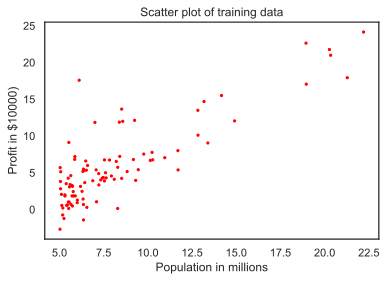

In [4]:
# declaring x and y variables for the 'm' training examples
x = df["profit"].values
y = df["population"].values
m = x.shape[0]                 

# create a scatter plot of the data
plt.scatter(x, y, s=5, c='red')
plt.title("Scatter plot of training data")
plt.xlabel("Population in millions")
plt.ylabel("Profit in $10000)")
plt.show()

# insert a column of 1’s as the last entry in the features
x = np.c_[np.ones(m), x]
y = y.reshape((y.shape[0], 1))

As you noticed, before implementing Gradient Descent, I used a technique called the *"bias trick"*. What it means? That I combined $w_0$ and $w_1$ togheter (I added an extra dimension (column) to the input data $x$).

### 1.2 Cost and Gradient Descent

Now we are going to implement a class to estimate the parameters of the regression line that minimizes the sum of the mean squared errors.

In [5]:
class LinearRegressionGD():
    def __init__(self, alpha=0.01, n_iter=1500):
        self.alpha = alpha
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.cost = []
        self.m_ = X.shape[0]
        self.w_ = np.random.randn(X.shape[1], 1)
        self.param_hist = np.array([self.w_[0].item(), self.w_[1].item()])
        
        for i in range(self.n_iter):
            w0 = self.w_[0].item()
            w1 = self.w_[1].item()
            output = self.predict(X)
            errors = output - y
            self.cost.append(self.calculate_cost(X, y, self.w_))
            temp = np.array([w0, w1])
            self.param_hist = np.vstack((self.param_hist, temp))
            #self.param_hist = .extend([w0, w1])
            self.w_ -= (self.alpha / (self.m_)) * (np.dot(X.T, errors))
            
    def predict(self, X):
        return np.dot(X, self.w_)
    
    @staticmethod
    def calculate_cost(X, y, W):
        cost = np.dot(X, W) - y
        cost = (1 / (2 * X.shape[0])) * (np.power(cost, 2).sum())
        return cost

#### Computing the cost

As you perform gradient descent to learn minimize the cost function, it is helpful to monitor the convergence by computing the cost. In this section, you will implement a function to calculate it so you can check the convergence of your gradient descent implementation.

In [6]:
# some algorithm tests
theta = np.array([[0.],[0.]])
cost= LinearRegressionGD.calculate_cost(x, y, theta)

# print the parameters found
print("[+] Testing the cost function...")
print("\tWith W = [0 ; 0]:\n\tCost computed = {:.4f}".format(cost))
print("\n[INFO] Expected cost value (approx) 32.07")

[+] Testing the cost function...
	With W = [0 ; 0]:
	Cost computed = 32.0727

[INFO] Expected cost value (approx) 32.07


In [7]:
# some algorithm tests
theta = np.array([[-1.],[2.]])
cost= LinearRegressionGD.calculate_cost(x, y, theta)

# print the parameters found
print("[+] Testing the cost function...")
print("\tWith W = [-1 ; 2]:\n\tCost computed = {:.4f}".format(cost))
print("\n[INFO] Expected cost value (approx) 54.24")

[+] Testing the cost function...
	With W = [-1 ; 2]:
	Cost computed = 54.2425

[INFO] Expected cost value (approx) 54.24


In [8]:
print("[INFO] Running Gradient Descent...\n")
model = LinearRegressionGD()
model.fit(x, y)
theta = model.w_

print("[+] Theta found by gradient descent:")
print("\tw0: \t{:.4f}\n\tw1: \t{:.4f}".format(theta[0][0], theta[1][0]))
print("\n[INFO] Expected theta values (approx):\n\tw0:\t -3.6303\n\tw1:\t 1.1664")

[INFO] Running Gradient Descent...

[+] Theta found by gradient descent:
	w0: 	-3.6330
	w1: 	1.1666

[INFO] Expected theta values (approx):
	w0:	 -3.6303
	w1:	 1.1664


#### Making predictions

Your final values for $W$ will also be used to make predictions on profits in areas of 35,000 and 70,000 people.

In [9]:
predict1 = model.predict([1, 3.5])*10000
predict2 = model.predict([1, 7])*10000

print('For population = 35,000, we predict a profit of {:.4f}'.format(predict1.item()))
print('For population = 70,000, we predict a profit of {:.4f}'.format(predict2.item()))

For population = 35,000, we predict a profit of 4502.0235
For population = 70,000, we predict a profit of 45334.3284


#### Plot the linear fit

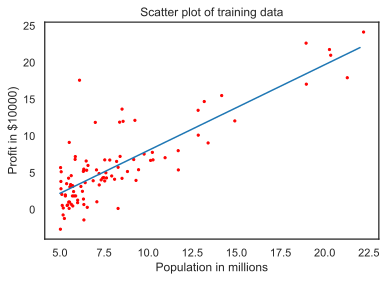

In [10]:
# create a scatter plot of the data
zx = np.arange(5, 23)
zx = np.c_[np.ones(zx.shape[0]), zx]
zy = np.dot(zx, theta)

plt.scatter(x[:,1], y, s=5, c='red')
plt.plot(zx[:,1], zy)
plt.title("Scatter plot of training data")
plt.xlabel("Population in millions")
plt.ylabel("Profit in $10000)")
plt.show()

### 1.4 Visualizing $J(\theta)$

To understand the cost function $J(\theta)$ better, you will now plot the cost over a 2-dimensional grid of $\theta_0 \text{ and } \theta_1$ values.

After the code below is executed, you will have a 2-D array of $J(\theta)$ values. The script will then use these values to produce surface and contour plots of $J(\theta)$ using the surf and contour commands.

In [11]:
###################################################
# The code below for surface and contour plotting #
# was copied from https://goo.gl/W2hehU           #
###################################################

# create grid coordinates for plotting
w0 = np.linspace(-10, 10, 100)
w1 = np.linspace(-1, 4, 100)
xx, yy = np.meshgrid(w0, w1, indexing='xy')
Z = np.zeros((w0.size, w1.size))

for (i,j), v in np.ndenumerate(Z):
    theta = np.array([[xx[i,j]],[yy[i,j]]])
    Z[i,j] = LinearRegressionGD.calculate_cost(x, y, theta)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, np.logspace(-2, 3, 20), cmap=plt.cm.jet)
ax1.scatter(model.w_[0],model.w_[1], c='r')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=1, cstride=1, alpha=0.8, cmap=cm.jet, linewidth=0, antialiased=False,)
ax2.set_zlabel('Cost', fontsize=10)
ax2.set_zlim(Z.min(),Z.max())
ax2.view_init(elev=15, azim=230)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\theta_0$', fontsize=10)
    ax.set_ylabel(r'$\theta_1$', fontsize=10)

plt.show()

The purpose of these graphs is to show you that how $J(\theta)$ varies with changes in $\theta_0$ and $\theta_1$. The cost function $J(\theta)$ is bowl-shaped and has a global mininum. (This is easier to see in the contour plot than in the 3D surface plot). 

This minimum is the optimal point for $\theta_0$ and $\theta_1$, and each step of gradient descent moves closer to this point.

## 2. Linear Regression with multiple variables

<br>



**coming soon...**

**coming soon...**

**coming soon...**